# Music Transformer

Sources:
- https://magenta.tensorflow.org/music-transformer
- https://arxiv.org/abs/1809.04281
- https://github.com/spectraldoy/music-transformer
- https://magenta.tensorflow.org/datasets/maestro

## Setup

In [1]:
!sudo apt install -y fluidsynth
%pip install --upgrade pyfluidsynth
%pip install pretty_midi
%pip install mido

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fluidsynth is already the newest version (2.2.5-1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cu117


In [4]:
import collections
import datetime
import time
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import seaborn as sns

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from math import sqrt

from matplotlib import pyplot as plt
from tqdm import tqdm

import pretty_midi
import mido

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [5]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

## MIDI Preprocessing

- Process one Midi file at a time
- For each file, convert midi into a token sequence (Tensor of Ints) and store sequences in a list
- Randomly sample a section of each tensor close to length lth and store in a list
- Randomly sample the end of each tensor close to length lth and store in the same list
- For each sequence, add pitch and time augmentation. Each augmented sequence is a Tensor, and stored in a list
- Add start and end tokens to each sequence
- Concatenate the list of tensors into a single tensor with padding up to the maximum length

Final Tensor dims = (2 * n_files * n_aug, max_seq_len)

### Download

In [6]:
import os
import urllib.request
import zipfile
from pathlib import Path

# Define the directory where data will be stored
data_dir = Path('data/maestro-v3.0.0')

# Check if the data directory already exists
if not data_dir.exists():
    os.makedirs(data_dir)

    # URL of the file to be downloaded
    url = 'https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip'

    # Define the local path where the zip file will be saved
    zip_path = Path('data/maestro-v3.0.0-midi.zip')

    # Download the file from the given URL
    print(f'Downloading {url}...')
    urllib.request.urlretrieve(url, zip_path)

    # Extract the contents of the zip file
    print('Extracting files...')
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('data/')

    # Remove the zip file after extraction
    os.remove(zip_path)

Extracting files...


### Vocabulary

In [7]:
"""
Vocabulary described in Oore et. al, 2018 and helper functions

Possible MIDI events being considered:
    128 note_on events
    128 note_off events
    125 time_shift events #time_shift = 1: 8 ms
    32  velocity events

Total midi events = 413

Indices in the vocabulary:
v[       0] = '<pad>'
v[  1..128] = note_on
v[129..256] = note_off
v[257..381] = time_shift
v[382..413] = velocity
v[414..415] = '<start>', '<end>'
"""

note_on_events = 128
note_off_events = note_on_events
note_events = note_on_events + note_off_events
time_shift_events = 125
velocity_events = 32
total_midi_events = note_on_events + note_off_events + time_shift_events + velocity_events

LTH = 1000
DIV = LTH // time_shift_events  # 1 time_shift = DIV milliseconds

BIN_STEP = 128 // velocity_events  # number of velocities per bin

print(f'Note ON Events: {note_on_events}')
print(f'Note OFF Events: {note_off_events}')
print(f'Time Shift Events: {time_shift_events}')
print(f'Velocity Events: {velocity_events}')
print(f'Total Midi Events (vocab_size): {total_midi_events}')

print(f'MS per time shift: {DIV}')
print(f'Velocity values per bin: {BIN_STEP}')

Note ON Events: 128
Note OFF Events: 128
Time Shift Events: 125
Velocity Events: 32
Total Midi Events (vocab_size): 413
MS per time shift: 8
Velocity values per bin: 4


In [8]:
# create vocabulary
note_on_vocab = [f"note_on_{i}" for i in range(note_on_events)]
note_off_vocab = [f"note_off_{i}" for i in range(note_off_events)]
time_shift_vocab = [f"time_shift_{i}" for i in range(time_shift_events)]
velocity_vocab = [f"set_velocity_{i}" for i in range(velocity_events)]

vocab = ['<pad>'] + note_on_vocab + note_off_vocab + time_shift_vocab + velocity_vocab + ['<start>', '<end>']
vocab_size = len(vocab)

# useful tokens
pad_token = vocab.index("<pad>")
start_token = vocab.index("<start>")
end_token = vocab.index("<end>")

In [9]:
def events_to_indices(event_list, _vocab=None):
    """
    converts event_list to list of indices in vocab
    """
    if _vocab is None:
        _vocab = vocab
    index_list = []
    for event in event_list:
        index_list.append(_vocab.index(event))
    return index_list


def indices_to_events(index_list, _vocab=None):
    """
    converts index_list to list of events in vocab
    """
    if _vocab is None:
        _vocab = vocab
    event_list = []
    for idx in index_list:
        event_list.append(_vocab[idx])
    return event_list

In [10]:
idx = events_to_indices(['<pad>', 'note_on_0', 'note_off_0', 'time_shift_0', 'set_velocity_0', '<start>', '<end>'])
evt = indices_to_events(idx)
print(dict(zip(evt, idx)))

{'<pad>': 0, 'note_on_0': 1, 'note_off_0': 129, 'time_shift_0': 257, 'set_velocity_0': 382, '<start>': 414, '<end>': 415}


In [11]:
def velocity_to_bin(velocity, step=BIN_STEP):
    """
    Velocity in midi is an int between 0 and 127 inclusive, which is unnecessarily high resolution
    To reduce number of events in vocab, velocity is resolved into (128 / step) bins

    Returns:
        _bin (int): bin into which velocity is placed
    """
    if 128 % step != 0:
        raise ValueError("128 must be divisible by bins")
    if not (0 <= velocity <= 127):
        raise ValueError(f"velocity must be between 0 and 127, not {velocity}")

    # return bin into which velocity is placed
    _bin = velocity // step
    return _bin


def bin_to_velocity(_bin, step=BIN_STEP):
    """
    Convert binned velocity to midi velocity
    (i.e., convert from [0, velocity_events] -> [0, 127]
    """
    if not (0 <= _bin * step <= 127):
        raise ValueError(f"bin * step must be between 0 and 127 to be a midi velocity, not {_bin * step}")

    return int(_bin * step)

In [12]:
def time_to_events(delta_time, event_list=None, index_list=None, _vocab=None):
    """
    Translate accumulated delta_time between midi events into vocab using time_cutter
    event_list and index_list are passed by reference, so nothing is returned.
    Pass-by-reference is necessary to execute this function within a loop.

    Args:
        delta_time (int): time (ms) between midi events
        event_list (list): accumulated vocab event list during midi translation
        index_list (list): accumulated vocab index list during midi translation
        _vocab (list, optional): vocabulary list to translate into
    """
    if _vocab is None:
        _vocab = vocab
    time = time_cutter(delta_time)
    for i in time:
        # repeatedly create and append time events to the input lists
        idx = note_on_events + note_off_events + i
        if event_list is not None:
            event_list.append(_vocab[idx])
        if index_list is not None:
            index_list.append(idx)
    return


def time_cutter(time, lth=LTH, div=DIV):
    """
    As per Oore et. al, 2018, the time between midi events must be expressed as a sequence of finite-length
    time segments, so as to avoid considering every possible length of time in the vocab. This sequence can be
    expressed as k instances of a maximum time shift followed by a leftover time shift, i.e.,
    time = k * max_time_shift + leftover_time_shift
    where k = time // max_time_shift; leftover_time_shift = time % max_time_shift

    This function will translate the input time into indices in the vocabulary then cut it as above

    Args:
        time (int > 0): input milliseconds to translate and cut
        lth (int, optional): max milliseconds to consider for vocab, i.e., max_time_shift
        div (int, optional): number of ms per time_shift;
                   lth // div = num_time_shift_events

    Returns:
        time_shifts (list): list of time shifts into which time is cut
                            each time_shift is in range: (1, lth // div); 0 is not considered
    """
    if lth % div != 0:
        raise ValueError("lth must be divisible by div")

    time_shifts = []

    # assume time = k * lth, k >= 0; add k max_time_shifts (lth // div) to time_shifts
    for i in range(time // lth):
        time_shifts.append(int(np.round(lth / div)))
    leftover_time_shift = int(np.round((time % lth) / div))
    time_shifts.append(leftover_time_shift) if leftover_time_shift > 0 else None

    return time_shifts

In [13]:
evt_list = []
time_to_events(2005, evt_list)
print(evt_list)

['time_shift_124', 'time_shift_124', 'time_shift_0']


### Tokenization

In [14]:
filenames = glob.glob(str(data_dir/'**/*.mid*'))
print(len(filenames))
sample_file = filenames[1]

def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

pm = pretty_midi.PrettyMIDI(sample_file)
display_audio(pm)

1276


In [15]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    notes = collections.defaultdict(list)

    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
        start = note.start
        end = note.end
        notes['pitch'].append(note.pitch)
        notes['start'].append(start)
        notes['end'].append(end)
        notes['step'].append(start - prev_start)
        notes['duration'].append(end - start)
        prev_start = start

    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
    if count:
        title = f'First {count} notes'
    else:
        title = f'Whole track'
        count = len(notes['pitch'])
    plt.figure(figsize=(20, 4))
    plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
    plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
    plt.plot(plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
    plt.xlabel('Time [s]')
    plt.ylabel('Pitch')
    _ = plt.title(title)

raw_notes = midi_to_notes(sample_file)
raw_notes.head()

pitch     start       end      step  duration
0     46  0.966667  1.505208  0.000000  0.538542
1     58  0.973958  1.478125  0.007292  0.504167
2     57  1.532292  1.585417  0.558333  0.053125
3     45  1.532292  1.625000  0.000000  0.092708
4     58  1.620833  1.672917  0.088542  0.052083

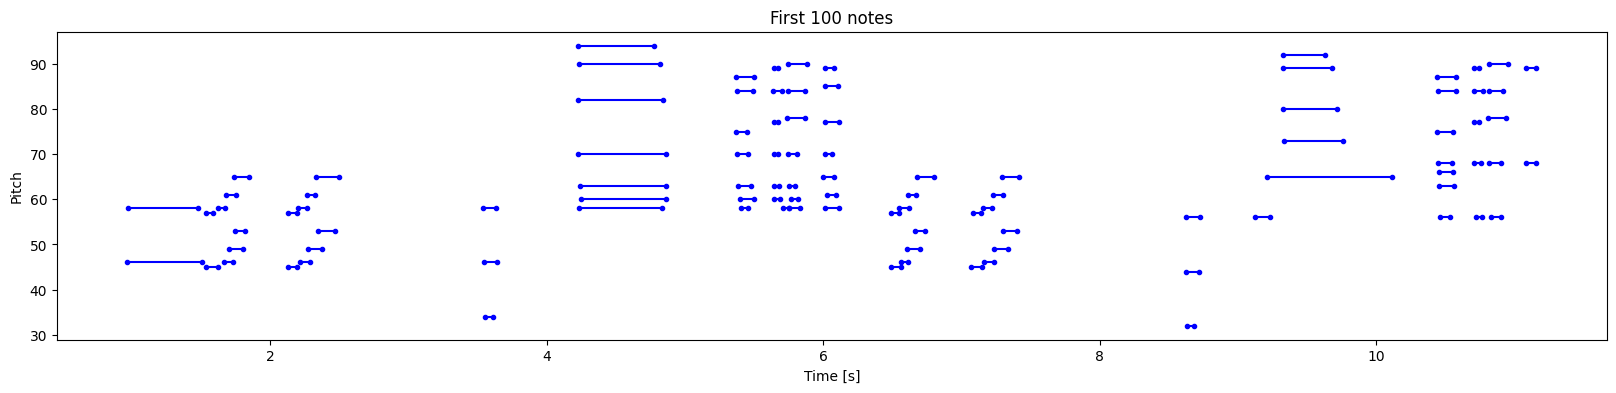

In [16]:
plot_piano_roll(raw_notes, 100)

In [17]:
mid = mido.MidiFile(sample_file)
for i, track in enumerate(mid.tracks):
    print('Track {}: {}'.format(i, track.name))
    for msg in track[:30]:
        if (i == 0) or (msg.type == 'note_on') or msg.type == 'note_off' or (msg.type == 'control_change' and msg.control == 64):
        # if (msg.type == 'note_off'):
            print(msg)

Track 0: 
MetaMessage('set_tempo', tempo=500000, time=0)
MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0)
MetaMessage('end_of_track', time=1)
Track 1: 
control_change channel=0 control=64 value=37 time=0
control_change channel=0 control=64 value=38 time=28
control_change channel=0 control=64 value=39 time=49
control_change channel=0 control=64 value=40 time=39
control_change channel=0 control=64 value=41 time=51
note_on channel=0 note=46 velocity=30 time=761
note_on channel=0 note=58 velocity=35 time=7
control_change channel=0 control=64 value=42 time=239
note_on channel=0 note=58 velocity=0 time=245
note_on channel=0 note=46 velocity=0 time=26
control_change channel=0 control=64 value=41 time=20
note_on channel=0 note=45 velocity=36 time=6
note_on channel=0 note=57 velocity=44 time=0
control_change channel=0 control=64 value=40 time=30
control_change channel=0 control=64 value=39 time=21
note_on channel=0 note=57 vel

Updates
- Convert delta_time to ms (as was intended) instead of ticks
- Note_on with velocity=0 counts as note_off (when the midi file is structured this way, it allows the pedal to take effect)
- Add note_off events for remaining pedal events at the end
- Refactor so all handling is within the if block

In [18]:
def midi_parser(fname=None, mid=None, use_pedal=True):
    """
    Translates a single-track midi file (specifically piano) into Oore et. al, 2018 vocabulary

    Args:
        fname (str): path to midi file to load OR
        mid (mido.MidiFile): loaded midi file

    Returns:
        index_list (torch.Tensor): list of indices in vocab
        event_list (list): list of events in vocab
    """
    # take only one of fname or mid
    if not ((fname is None) ^ (mid is None)):
        raise ValueError("Input one of fname or mid, not both or neither")

    # load midi file
    if fname is not None:
        try:
            mid = mido.MidiFile(fname)
        except mido.midifiles.meta.KeySignatureError as e:
            raise ValueError(e)

    # things needed for conversion
    delta_time = 0          # time between important midi messages
    event_list = []         # list of events in vocab
    index_list = []         # list of indices in vocab
    pedal_events = {}       # dict to handle pedal events
    pedal_flag = False      # flag to handle pedal events
    tempo = 0               # tempo of midi file (us/beat)
    ms_per_tick = 0        # number of seconds per tick

    ticks_per_beat = mid.ticks_per_beat

    # translate midi file to event list
    for track in mid.tracks:
        for msg in track:
            # increase delta_time by msg time for all messages
            # delta_time += msg.time
            delta_time += int(mido.tick2second(msg.time, ticks_per_beat, tempo) * 1e3)

            # meta events are irrelevant
            if msg.is_meta:
                if (msg.type == "set_tempo") and (tempo == 0):
                    tempo = msg.tempo
                    ms_per_tick = tempo / 1e3 / ticks_per_beat
                continue

            # process by message type
            t = msg.type
            vel = 0   # velocity

            if t == "note_on" and msg.velocity > 0:  # key pressed

                time_to_events(delta_time, event_list=event_list, index_list=index_list)
                delta_time = 0

                # add velocity event
                vel = velocity_to_bin(msg.velocity)
                event_list.append(vocab[note_on_events + note_off_events + time_shift_events + vel + 1])
                index_list.append(note_on_events + note_off_events + time_shift_events + vel + 1)

                # append event and idx note events
                # +1 or-1 everywhere accounts for <pad> token
                idx = msg.note + 1  # idx in vocab to help appending to output lists
                event_list.append(vocab[idx])
                index_list.append(idx)

                continue

            elif t == "note_off" or (t == 'note_on' and msg.velocity == 0):  # key released
                note = msg.note

                # if note_off while pedal down, add to pedal_events
                if pedal_flag and use_pedal:
                    pedal_events[note] = 1
                    # to prevent adding more events to output lists, continue
                    continue

                time_to_events(delta_time, event_list=event_list, index_list=index_list)
                delta_time = 0  # reset delta_time to process subsequent messages

                idx = note_on_events + note + 1
                event_list.append(vocab[idx])
                index_list.append(idx)

                continue

            # if pedal on or off and pedal_events is not empty
            elif t == "control_change":
                if msg.control == 64:
                    if msg.value >= 64:
                        # pedal down
                        pedal_flag = True
                    elif pedal_events:
                        # lift pedal
                        pedal_flag = False

                        if not pedal_events:
                            continue

                        # add the time events (0 is not a time shift, so all notes lifted at once is ok)
                        time_to_events(delta_time, event_list=event_list, index_list=index_list)
                        delta_time = 0

                        # perform note_offs that occurred when pedal was down now that pedal is up
                        for note in pedal_events:
                            idx = note_on_events + note + 1
                            event_list.append(vocab[idx])
                            index_list.append(idx)
                        # restart pedal events dict
                        pedal_events = {}
                # to prevent adding more events to output lists, continue
                continue
            # if it's not a type of msg we care about, continue to avoid adding to output lists
            else:
                continue

        # End any notes waiting in the pedal_events
        if pedal_flag and pedal_events:
            time_to_events(delta_time, event_list=event_list, index_list=index_list)
            for note in pedal_events:
                idx = note_on_events + note + 1
                event_list.append(vocab[idx])
                index_list.append(idx)

    # return the lists of events
    return torch.IntTensor(index_list), event_list, tempo


In [19]:
def midi_parser2(fname=None, mid=None):
    """
    Translates a single-track midi file (specifically piano) into Oore et. al, 2018 vocabulary

    Args:
        fname (str): path to midi file to load OR
        mid (mido.MidiFile): loaded midi file

    Returns:
        index_list (torch.Tensor): list of indices in vocab
        event_list (list): list of events in vocab
    """
    # take only one of fname or mid
    if not ((fname is None) ^ (mid is None)):
        raise ValueError("Input one of fname or mid, not both or neither")

    # load midi file
    if fname is not None:
        try:
            mid = mido.MidiFile(fname)
        except mido.midifiles.meta.KeySignatureError as e:
            raise ValueError(e)

    # things needed for conversion
    delta_time = 0          # time between important midi messages
    event_list = []         # list of events in vocab
    index_list = []         # list of indices in vocab
    pedal_events = {}       # dict to handle pedal events
    pedal_flag = False      # flag to handle pedal events

    tempo = 0               # tempo of midi file
    # translate midi file to event list
    for track in mid.tracks:
        for msg in track:
            # increase delta_time by msg time for all messages
            delta_time += msg.time

            # meta events are irrelevant
            if msg.is_meta:
                if (msg.type == "set_tempo") and (tempo == 0):
                    tempo = msg.tempo
                continue

            # process by message type
            t = msg.type
            vel = 0   # velocity

            if t == "note_on":  # key pressed
                # +1 or-1 everywhere accounts for <pad> token
                idx = msg.note + 1  # idx in vocab to help appending to output lists

                # get velocity to append after time events
                vel = velocity_to_bin(msg.velocity)

            elif t == "note_off":  # key released
                note = msg.note

                # if note_off while pedal down, add to pedal_events
                if pedal_flag:
                    if note not in pedal_events:
                        pedal_events[note] = 0
                    pedal_events[note] += 1
                    # to prevent adding more events to output lists, continue
                    continue
                else:  # else get idx to append to output lists
                    idx = note_on_events + note + 1
            # if pedal on or off and pedal_events is not empty
            elif t == "control_change":
                if msg.control == 64:
                    if msg.value >= 64:
                        # pedal down
                        pedal_flag = True
                    elif pedal_events:
                        # lift pedal
                        pedal_flag = False

                        # add the time events (0 is not a time shift, so all notes lifted at once is ok)
                        time_to_events(delta_time, event_list=event_list, index_list=index_list)
                        delta_time = 0

                        # perform note_offs that occurred when pedal was down now that pedal is up
                        for note in pedal_events:
                            idx = note_on_events + note + 1

                            # append a note_off event for all times note was released
                            for i in range(pedal_events[note]):
                                event_list.append(vocab[idx])
                                index_list.append(idx)
                        # restart pedal events dict
                        pedal_events = {}
                # to prevent adding more events to output lists, continue
                continue
            # if it's not a type of msg we care about, continue to avoid adding to output lists
            else:
                continue

            # process delta_time into events and indices in vocab
            time_to_events(delta_time, event_list=event_list, index_list=index_list)
            delta_time = 0  # reset delta_time to process subsequent messages

            # append velocity if note_on
            if t == "note_on":
                event_list.append(vocab[note_on_events + note_off_events + time_shift_events + vel + 1])
                index_list.append(note_on_events + note_off_events + time_shift_events + vel + 1)
            # append event and idx note events
            event_list.append(vocab[idx])
            index_list.append(idx)

    # return the lists of events
    return torch.IntTensor(index_list), event_list, tempo


In [20]:
a = midi_parser(sample_file, use_pedal=True)

In [21]:
b = midi_parser2(sample_file)

Updates:
- Account for tempo and ticks_per_beat when converting time
- Don't set velocity back to 0 after each note
- Provide note_off events at the end for any unmatched note_on

In [22]:
def list_parser(index_list=None, event_list=None, fname="bloop", tempo=500000):
    """
    Translates a set of events or indices in the Oore et. al, 2018 vocabulary into a midi file

    Args:
        index_list (list or torch.Tensor): list of indices in vocab OR
        event_list (list): list of events in vocab
        fname (str, optional): name for single track of midi file returned
        tempo (int, optional): tempo of midi file returned in µs / beat,
                               tempo_in_µs_per_beat = 60 * 1e6 / tempo_in_bpm

    Returns:
        mid (mido.MidiFile): single-track piano midi file translated from vocab
                             NOTE: mid IS NOT SAVED BY THIS FUNCTION, IT IS ONLY RETURNED
    """
    # take only one of event_list or index_list to translate
    if not ((index_list is None) ^ (event_list is None)):
        raise ValueError("Input one of index_list or event_list, not both or neither")

    # check index_list is ints, assuming 1d list
    if index_list is not None:
        try:
            # assume torch tensor
            if not all([isinstance(i.item(), int) for i in index_list]):
                raise ValueError("All indices in index_list must be int type")
        except AttributeError:
            # otherwise assume normal ,jst
            if not all([isinstance(i, int) for i in index_list]):
                raise ValueError("All indices in index_list must be int type")

    # check event_list is str, assuming 1d list and convert to index_list
    if event_list is not None:
        if not all(isinstance(i, str) for i in event_list):
            raise ValueError("All events in event_list must be str type")
        index_list = events_to_indices(event_list)

    # set up midi file
    mid = mido.MidiFile()
    meta_track = mido.MidiTrack()
    track = mido.MidiTrack()

    # meta messages; meta time is 0 everywhere to prevent delay in playing notes
    meta_track.append(mido.MetaMessage("track_name").copy(name=fname, time=0))
    meta_track.append(mido.MetaMessage("smpte_offset"))
    # assume time_signature is 4/4
    time_sig = mido.MetaMessage("time_signature")
    time_sig = time_sig.copy(numerator=4, denominator=4, time=0)
    meta_track.append(time_sig)
    # assume key_signature is C
    key_sig = mido.MetaMessage("key_signature", time=0)
    meta_track.append(key_sig)
    # assume tempo is constant at input tempo
    set_tempo = mido.MetaMessage("set_tempo")
    set_tempo = set_tempo.copy(tempo=tempo, time=0)
    meta_track.append(set_tempo)
    # end of meta track
    end = mido.MetaMessage("end_of_track").copy(time=0)
    meta_track.append(end)

    # set up the piano; default channel is 0 everywhere; program=0 -> piano
    program = mido.Message("program_change", channel=0, program=0, time=0)
    track.append(program)
    # dummy pedal off message; control should be < 64
    cc = mido.Message("control_change", time=0)
    track.append(cc)

    # things needed for conversion
    ticks_per_beat = mid.ticks_per_beat
    delta_time = 0
    vel = 0

    # Track active note events for ending
    note_events = {}

    # reconstruct the performance
    for idx in index_list:
        # if torch tensor, get item
        try:
            idx = idx.item()
        except AttributeError:
            pass
        # if pad token, continue
        if idx <= 0:
            continue
        # adjust idx to ignore pad token
        idx = idx - 1

        # note messages
        if 0 <= idx < note_on_events + note_off_events:
            # note on event
            if 0 <= idx < note_on_events:
                note = idx
                t = "note_on"
                v = vel  # get velocity from previous event
                note_events[note] = 1
            # note off event
            else:
                note = idx - note_on_events
                t = "note_off"
                v = 127
                if note in note_events:
                    del note_events[note]

            # create note message and append to track
            msg = mido.Message(t)
            msg = msg.copy(note=note, velocity=v, time=mido.second2tick(delta_time / 1.0e3, ticks_per_beat, tempo))
            track.append(msg)

            # reinitialize delta_time and velocity to handle subsequent notes
            delta_time = 0
            # vel = 0

        # time shift event
        elif note_on_events + note_off_events <= idx < note_on_events + note_off_events + time_shift_events:
            # find cut time in range (1, time_shift_events)
            cut_time = idx - (note_on_events + note_off_events - 1)
            # scale cut_time by DIV (from vocabulary) to find time in ms; add to delta_time
            delta_time += cut_time * DIV

        # velocity event
        elif note_on_events + note_off_events + time_shift_events <= idx < total_midi_events:
            # get velocity for next note_on in range (0, 127)
            vel = bin_to_velocity(idx - (note_on_events + note_off_events + time_shift_events))

    # Close any open note_on events
    for note in note_events:
        track.append(mido.Message('note_off', note=note, velocity=127, time=mido.second2tick(delta_time / 1.0e3, ticks_per_beat, tempo)))

    # end the track
    end = mido.MetaMessage("end_of_track").copy(time=0)
    track.append(end)

    # append finalized track and return midi file
    mid.tracks.append(meta_track)
    mid.tracks.append(track)
    return mid

In [23]:
mid_back = list_parser(a[0])
mid_back.save('mid_back.mid')

In [24]:
pm = pretty_midi.PrettyMIDI('./mid_back.mid')
display_audio(pm)

In [25]:
mid_back_2 = list_parser(b[0])
mid_back_2.save('mid_back_2.mid')

In [26]:
pm = pretty_midi.PrettyMIDI('./mid_back.mid')
display_audio(pm)

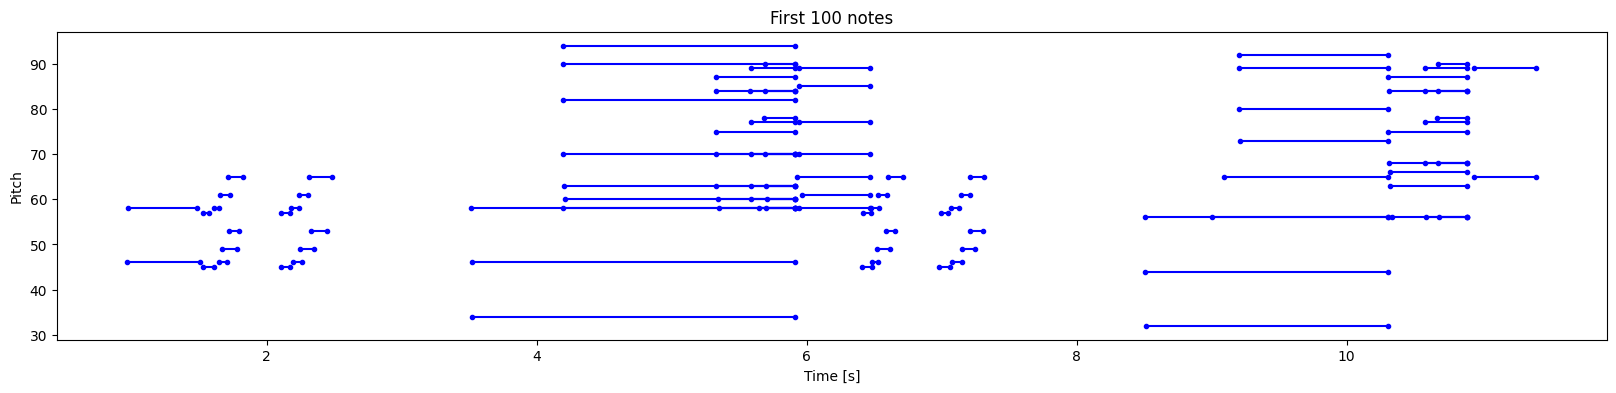

In [27]:
raw_notes = midi_to_notes('./mid_back.mid')
plot_piano_roll(raw_notes, 100)

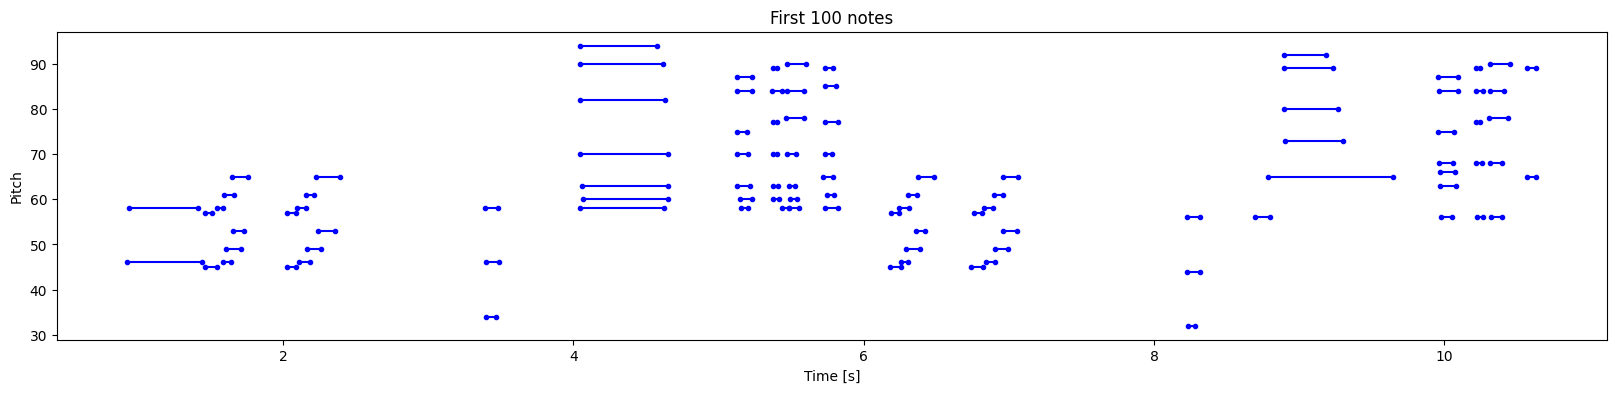

In [28]:
raw_notes_2 = midi_to_notes('./mid_back_2.mid')
plot_piano_roll(raw_notes_2, 100)

In [29]:
events=[
    'set_velocity_30',
    'note_on_64',
    'time_shift_124',
    'set_velocity_0',
    'note_on_64',
    'time_shift_124',
    'time_shift_124',
    'set_velocity_30',
    'note_on_64',
    'time_shift_124',
]
mid_test = list_parser(None, events, tempo=250000)
mid_test.tracks[1].insert(2, mido.Message('control_change', control=64, value=124, time=1))
mid_test.tracks[1].insert(-1, mido.Message('control_change', control=64, value=0, time=800))
print(mid_test)
mid_test.save('./mid_test.mid')

mid_test_1 = midi_parser(mid=mid_test)[0]

mid_test_1_back = list_parser(mid_test_1)
print(mid_test_1_back)

mid_test_1_back.save('./mid_test_1.mid')

MidiFile(type=1, ticks_per_beat=480, tracks=[
  MidiTrack([
    MetaMessage('track_name', name='bloop', time=0),
    MetaMessage('smpte_offset', frame_rate=24, hours=0, minutes=0, seconds=0, frames=0, sub_frames=0, time=0),
    MetaMessage('time_signature', numerator=4, denominator=4, clocks_per_click=24, notated_32nd_notes_per_beat=8, time=0),
    MetaMessage('key_signature', key='C', time=0),
    MetaMessage('set_tempo', tempo=250000, time=0),
    MetaMessage('end_of_track', time=0)]),
  MidiTrack([
    Message('program_change', channel=0, program=0, time=0),
    Message('control_change', channel=0, control=0, value=0, time=0),
    Message('control_change', channel=0, control=64, value=124, time=1),
    Message('note_on', channel=0, note=64, velocity=120, time=0),
    Message('note_on', channel=0, note=64, velocity=0, time=1920),
    Message('note_on', channel=0, note=64, velocity=120, time=3840),
    Message('note_off', channel=0, note=64, velocity=127, time=1920),
    Message('cont

In [30]:
pm = pretty_midi.PrettyMIDI('./mid_test.mid')
display_audio(pm)

In [31]:
pm = pretty_midi.PrettyMIDI('./mid_test_1.mid')
display_audio(pm)

Note: Piano roll (and therefore pretty_midi data) is not accounting for the pedal

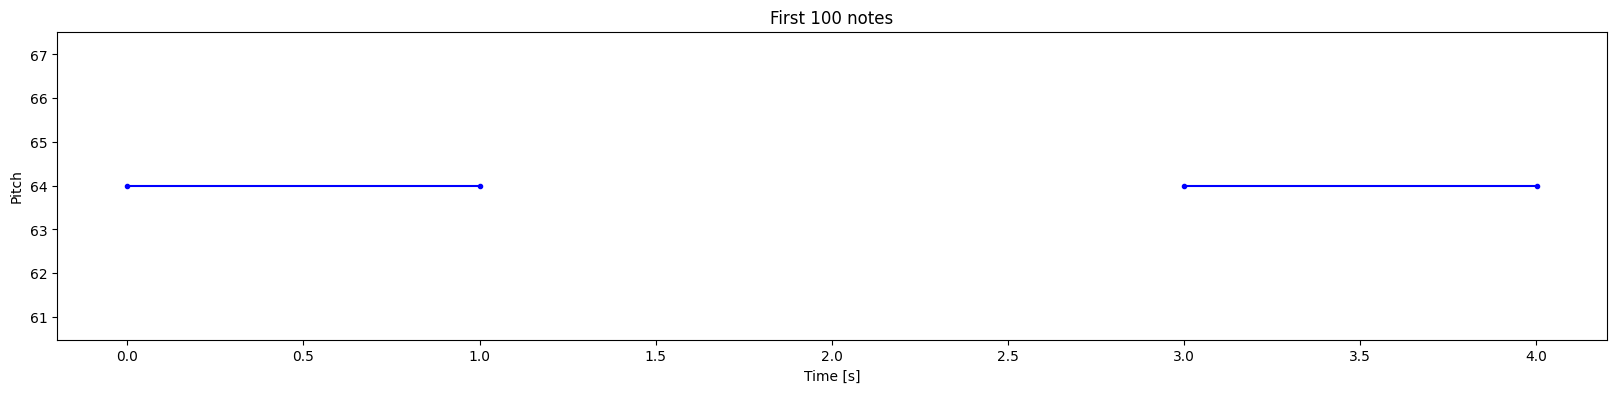

In [32]:
notes = midi_to_notes('./mid_test.mid')
plot_piano_roll(notes, 100)

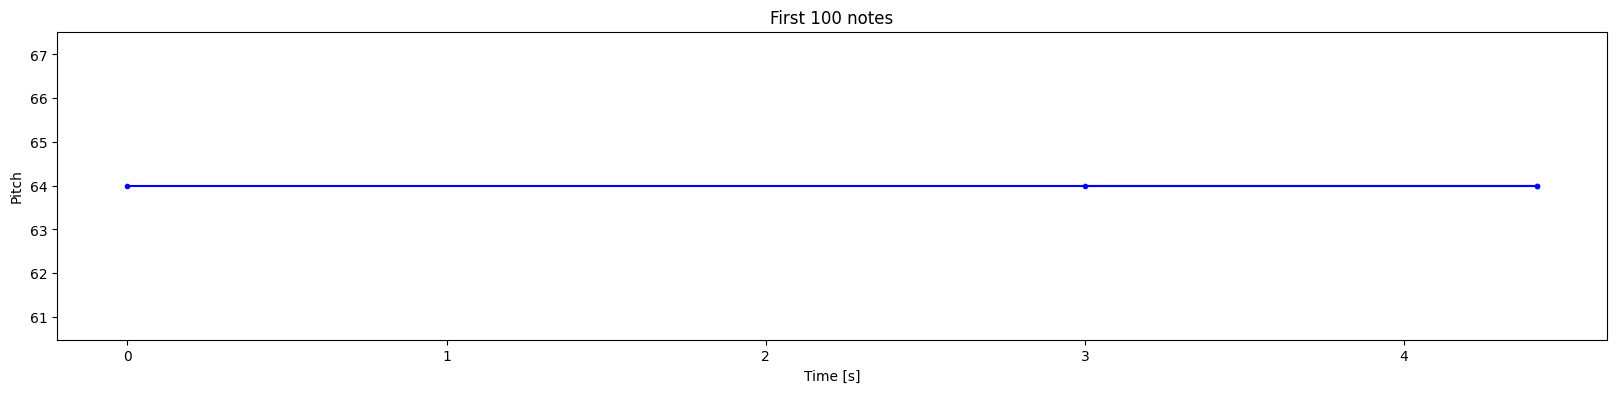

In [33]:
notes = midi_to_notes('./mid_test_1.mid')
plot_piano_roll(notes, 100)

### Preprocessing

In [34]:
from random import randint, sample

def sample_end_data(seqs, lth, factor=6):
    """
    Randomly samples sequences of length ~lth from an input set of sequences seqs. Prepares data for augmentation.
    Returns a list. Deliberately samples from the end so that model learns to end.

    Args:
        seqs (list): list of sequences in the event vocabulary
        lth (int): approximate length to cut sequences into
        factor (int): factor to vary range of output lengths; Default: 6. Higher factor will narrow the output range

    Returns:
        input sequs cut to length ~lth
    """
    data = []
    for seq in seqs:
        lower_bound = max(len(seq) - lth, 0)
        idx = randint(lower_bound, lower_bound + lth // factor)
        data.append(seq[idx:])

    return data


def sample_data(seqs, lth, factor=6):
    """
    Randomly samples sequences of length ~lth from an input set of sequences seqs. Prepares data for augmentation.
    Returns a list.

    Args:
        seqs (list): list of sequences in the event vocabulary
        lth (int): approximate length to cut sequences into
        factor (int): factor to vary range of output lengths; Default: 6. Higher factor will narrow the output range

    Returns:
        input sequs cut to length ~lth
    """
    data = []
    for seq in seqs:
        length = randint(lth - lth // factor, lth + lth // factor)
        idx = randint(0, max(0, len(seq) - length))
        data.append(seq[idx:idx+length])

    return data

In [35]:
sample_end_data([a[0]], 20, 5)

[tensor([381, 381, 288, 206, 194, 178, 190, 202, 197, 185, 166, 182, 173, 231,
         258, 154, 257, 230, 257, 166], dtype=torch.int32)]

In [36]:
sample_data([a[0]], 20, 5)

[tensor([400,  52, 262, 201, 209, 213, 261, 395,  57, 266, 404,  83, 257, 404,
          71, 397,  61, 269, 398,  67, 266, 397,  61, 264], dtype=torch.int32)]

Updates:
- Moved the delta_time=0 into the for loop for each time_stretch so there is no time left over from the previous sequence
- Fixed the time idx, which was off by 1

In [37]:
def aug(data, note_shifts=None, time_stretches=None, verbose=False):
    """
    Augments data up and down in pitch by note_shifts and faster and slower in time by time_stretches. Adds start
    and end tokens and pads to max sequence length in data

    Args:
        data (list of lists of ints): sequences to augment
        note_shifts (list): pitch transpositions to be made
        time_stretches (list): stretches in time to be made
        verbose (bool): set to True to periodically print augmentation progress

    Returns:
        input data with pitch transpositions and time stretches, concatendated to one tensor
    """
    if note_shifts is None:
        note_shifts = torch.arange(-2, 3)
    if time_stretches is None:
        time_stretches = [1, 1.05, 1.1]
    if any([i <= 0 for i in time_stretches]):
        raise ValueError("time_stretches must all be positive")

    # preprocess the time stretches
    if 1 not in time_stretches:
        time_stretches.append(1)
    ts = []
    for t in time_stretches:
        ts.append(t) if t not in ts else None
        ts.append(1 / t) if (t != 1 and 1 / t not in ts) else None
    ts.sort()
    time_stretches = ts

    print(f"Note shifts: {note_shifts}")
    print(f"Time stretches: {time_stretches}")

    # iteratively transpose and append the sequences
    note_shifted_data = []
    count = 0  # to print if verbose
    for seq in data:
        # data will be transposed by each shift in note_shifts
        for shift in note_shifts:
            # check torch tensor
            try:
                _shift = shift.item()
            except AttributeError:
                _shift = shift

            # iterate over and shift seq
            note_shifted_seq = []
            for idx in seq:
                _idx = idx + _shift  # shift the index

                # append only note values if changed, and don't go out of bounds of note events
                if (0 < idx <= note_on_events and 0 < _idx <= note_on_events) or \
                        (note_on_events < idx <= note_events and note_on_events < _idx <= note_events):
                    note_shifted_seq.append(_idx)
                else:
                    note_shifted_seq.append(idx)
            # verbose statement
            count += 1
            print(f"Transposed {count} sequences") if verbose else None
            # convert to tensor and append to data
            note_shifted_seq = torch.IntTensor(note_shifted_seq)
            note_shifted_data.append(note_shifted_seq)

    # now iterate over the note shifted data to stretch it in time
    time_stretched_data = []
    count = 0  # to print if verbose
    for seq in note_shifted_data:
        # data will be stretched in time by each time_stretch
        for time_stretch in time_stretches:
            # iterate over and stretch time shift events in seq
            time_stretched_seq = []
            delta_time = 0
            for idx in seq:
                if note_events < idx <= note_events + time_shift_events:
                    # acculumate stretched times
                    time = idx - note_events
                    delta_time += np.round(time * DIV * time_stretch).int()
                else:
                    time_to_events(delta_time, index_list=time_stretched_seq)
                    delta_time = 0
                    time_stretched_seq.append(idx)
            # verbose statement
            count += 1
            print(f"Stretched {count} sequences") if verbose else None
            # convert to tensor and append to data
            time_stretched_seq = torch.IntTensor(time_stretched_seq)
            time_stretched_data.append(time_stretched_seq)

    # preface and suffix with start and end tokens
    aug_data = []
    for seq in time_stretched_data:
        aug_data.append(F.pad(F.pad(seq, (1, 0), value=start_token), (0, 1), value=end_token))

    # pad all sequences to max length
    aug_data = torch.nn.utils.rnn.pad_sequence(aug_data, padding_value=pad_token).transpose(-1, -2)
    return aug_data

In [42]:
def randomly_sample_aug_data(aug_data, k, augs=25):
    """
    Randomly samples k sets of augmented data to cut down dataset

    Args:
        aug_data (torch.Tensor): augmented dataset
        k (int): coefficient such that k * augs samples are returned
        augs (int): total number of augmentations per sequence performed on original dataset
    """
    random_indices = sample(range(len(aug_data) // augs), k=k)
    out = torch.cat(
        [t[i * augs:i * augs + augs] for i in random_indices],
        dim=0
    )
    return out

In [43]:
data = []

# load parsed midi files
print("Translating midi files to event vocabulary (NOTE: may take a while)...")
for file in glob.iglob(str(data_dir/'**/*.mid*'), recursive=True):
    print(file)
    try:
        idx_list = midi_parser(fname=file)[0]
        data.append(idx_list)
    except (OSError, ValueError, EOFError) as ex:
        print(f"{type(ex).__name__} was raised: {ex}")
        pass
print("Done!")

'\ndata = []\n\n# load parsed midi files\nprint("Translating midi files to event vocabulary (NOTE: may take a while)...")\nfor file in glob.iglob(str(data_dir/\'**/*.mid*\'), recursive=True):\n    print(file)\n    try:\n        idx_list = midi_parser(fname=file)[0]\n        data.append(idx_list)\n    except (OSError, ValueError, EOFError) as ex:\n        print(f"{type(ex).__name__} was raised: {ex}")\n        pass\nprint("Done!")\n'

In [44]:
lth = 30
note_shifts = torch.arange(-2, 3)
time_stretches = [1, 1.05, 1.1]
verbose = False
dest = 'data_0.pt'
aug_dest = 'aug_data_0.pt'

# randomly sample endings
print("Randomly sampling and cutting data to length...")
sampled_data = sample_data(data, lth) + sample_end_data(data, lth)
print("Done!")

aug_data = sampled_data.copy()
pad_data = []
for seq in sampled_data:
    pad_data.append(F.pad(F.pad(seq, (1, 0), value=start_token), (0, 1), value=end_token))

# pad all sequences to max length
pad_data = torch.nn.utils.rnn.pad_sequence(pad_data, padding_value=pad_token).transpose(-1, -2)

# shuffle data
pad_data = pad_data[torch.randperm(pad_data.shape[0])]
print(pad_data.shape)

# save
print("Saving...")
torch.save(pad_data, dest)
print("Done!")

# augment data
print("Augmenting data (NOTE: may take even longer)...")
aug_data = aug(aug_data, note_shifts, time_stretches, verbose)
print("Done!")

# shuffle data
aug_data = aug_data[torch.randperm(aug_data.shape[0])]
print(aug_data.shape)

# save
print("Saving...")
torch.save(aug_data, aug_dest)
print("Done!")

'\nlth = 30\nnote_shifts = torch.arange(-2, 3)\ntime_stretches = [1, 1.05, 1.1]\nverbose = False\ndest = \'data_0.pt\'\naug_dest = \'aug_data_0.pt\'\n\n# randomly sample endings\nprint("Randomly sampling and cutting data to length...")\nsampled_data = sample_data(data, lth) + sample_end_data(data, lth)\nprint("Done!")\n\naug_data = sampled_data.copy()\npad_data = []\nfor seq in sampled_data:\n    pad_data.append(F.pad(F.pad(seq, (1, 0), value=start_token), (0, 1), value=end_token))\n\n# pad all sequences to max length\npad_data = torch.nn.utils.rnn.pad_sequence(pad_data, padding_value=pad_token).transpose(-1, -2)\n\n# shuffle data\npad_data = pad_data[torch.randperm(pad_data.shape[0])]\nprint(pad_data.shape)\n\n# save\nprint("Saving...")\ntorch.save(pad_data, dest)\nprint("Done!")\n\n# augment data\nprint("Augmenting data (NOTE: may take even longer)...")\naug_data = aug(aug_data, note_shifts, time_stretches, verbose)\nprint("Done!")\n\n# shuffle data\naug_data = aug_data[torch.randper

In [45]:
pad_data = torch.load('data_0.pt',)
sample_data = pad_data[10][5:9]
sample_data[1] = 255
sample_data[2] = 1 + 128 + 128
print(indices_to_events(sample_data))

"\npad_data = torch.load('data_0.pt',)\nsample_data = pad_data[10][5:9]\nsample_data[1] = 255\nsample_data[2] = 1 + 128 + 128\nprint(indices_to_events(sample_data))\n"

In [46]:
aug_sample_data = aug([sample_data])
for i in aug_sample_data:
    print(indices_to_events(i))

'\naug_sample_data = aug([sample_data])\nfor i in aug_sample_data:\n    print(indices_to_events(i))\n'

## Model

### Layers

In [47]:
from dataclasses import dataclass
hparams = {
    'vocab_size': vocab_size,
    'd_model': 128,
    'num_heads': 8,
    'num_layers': 3,
    'dropout': 0.1,
    'mult_d_ffwd': 4, # Multiplier on d_model to give the hidden dim of the ffwd layers
    'bias': True,
    'max_abs_position': 0,
    'max_rel_dist': 1024,
    'layernorm_eps': 1e-6,
    # 'flash_attn': False,
}

In [48]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Running on device: ", device)

Running on device:  cuda


In [49]:
print(f'Configuration Settings: {hparams}')

Configuration Settings: {'vocab_size': 416, 'd_model': 128, 'num_heads': 8, 'num_layers': 3, 'dropout': 0.1, 'mult_d_ffwd': 4, 'bias': True, 'max_abs_position': 0, 'max_rel_dist': 1024, 'layernorm_eps': 1e-06}


In [50]:
def abs_positional_encoding(max_position, d_model, n=3):
    """
    Since the transformer does not use recurrence or convolution, we have to deliberately give it positional
    information. Though learned relative position embeddings will be added to the model, it is possible that absolute
    position encoding will aid it in predicting next tokens.

    Args:
        max_position (int): maximum position for which to calculate positional encoding
        d_model (int): Transformer hidden dimension size
        n (int): number of dimensions to which to broadcast output

    Returns:
        sinusoidal absolute positional encoding of shape d_model for max_position positions
    """
    # set of all positions to consider
    positions = torch.arange(max_position).float().to(device)

    # get angles to input to sinusoid functions
    k = torch.arange(d_model).float().to(device)
    coeffs = 1 / torch.pow(10000, 2 * (k // 2) / d_model)
    angles = positions.view(-1, 1) @ coeffs.view(1, -1)

    # apply sin to the even indices of angles along the last axis
    angles[:, 0::2] = torch.sin(angles[:, 0::2])

    # apply cos to the odd indices of angles along the last axis
    angles[:, 1::2] = torch.cos(angles[:, 1::2])

    return angles.view(*[1 for _ in range(n-2)], max_position, d_model)

In [51]:
def skew(t):
    """
    Implements Huang et. al, 2018's skewing algorithm to correctly reorder the dot(Q, RelativePositionEmbeddings)
    matrix. This function generalizes to any shape and any number of dimensions. However, attention calculation
    requires shape (..., L, L).

    Algorithm:
        1. Pad T
        2. Reshape
        3. Slice

    Args:
        t (torch.Tensor): tensor to skew

    Returns:
        Srel: skewed t: nth column from the right is skewed into the nth diagonal under the main; same shape as t
    """
    # pad T
    padded = F.pad(t, [1, 0])

    # reshape to diagonalize the columns in the last 2 dimensions
    Srel = padded.reshape(-1, t.shape[-1] + 1, t.shape[-2])

    # final touches
    Srel = Srel[:, 1:]              # slice last L values
    Srel = Srel.reshape(*t.shape)   # reshape to shape of t
    return Srel


In [52]:
def rel_scaled_dot_prod_attention(q, k, v, e=None, mask=None):
    """
    A modification given by Shaw et. al, 2018, improved by Huang et. al, 2018, to the Scaled Dot-Product Attention
    mechanism given in Vaswani et. al, 2017, which allows the Transformer model to attend to all relevant elements of
    the input sequences as well as the relative distances between them.

    RelAttention = softmax( mask( QKT + skew(QET) ) / sqrt(d_k) ) V

    Args:
        q: Queries tensor of shape (..., seq_len_q, d_model)
        k: Keys tensor of shape (..., seq_len_k, d_model)
        v: Values tensor of shape (..., seq_len_k, d_model)
        e (optional): Relative Position Embeddings tensor of shape (seq_len_k, d_model)
        mask (optional): mask for input batch with ones indicating the positions to mask

    Returns:
        output attention of shape (..., seq_len_q, d_model)
    """
    QKt = torch.matmul(q, k.transpose(-1, -2))  # (..., seq_len_q, seq_len_k)

    if e is None:
        # assumes q.shape[:-2] == k.shape[:-2]
        Srel = torch.zeros(*q.shape[:-2], q.shape[-2], k.shape[-2], device=q.device)
    else:
        Srel = skew(torch.matmul(q, e.transpose(-1, -2)))  # (..., seq_len_q, seq_len_k)

    # find and scale attention logits
    dk = sqrt(k.shape[-1])
    scaled_attention_logits = (QKt + Srel) / dk  # (..., seq_len_q, seq_len_k)

    # add scaled mask to 0 out positions to mask in softmax
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # calculate attention by calculating attention weights by softmaxing on the last dimension
    # and then multiplying by v
    return torch.matmul(F.softmax(scaled_attention_logits, dim=-1), v)

In [53]:
class MultiHeadAttention(nn.Module):
    """
    MultiHead Relative Attention Block. Computes attention for input batch along num_heads "heads".
    In the process, attention weights are calculated num_heads times, which allows the network to
    extract information from the input batch through several different representations simultaneously
    """
    def __init__(self, d_model, num_heads, max_rel_dist, bias=True):
        """
        Args:
            d_model (int): Transformer hidden dimension size
            num_heads (int): number of heads along which to calculate attention
            max_rel_dist (int): maximum relative distance between positions to consider in creating
                                relative position embeddings; set to 0 to compute normal attention
            bias (bool, optional): if set to False, all Linear layers in the MHA block will not learn
                                   an additive bias. Default: True

        """
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        self.max_rel_dist = max_rel_dist
        self.batch_first = True

        if d_model % num_heads != 0:
            raise ValueError("d_model must be divisible into num_heads heads")

        self.depth = self.d_model // self.num_heads

        self.wq = nn.Linear(self.d_model, self.d_model, bias=bias)  # parameter matrix to generate Q from input
        self.wk = nn.Linear(self.d_model, self.d_model, bias=bias)  # parameter matrix to generate K from input
        self.wv = nn.Linear(self.d_model, self.d_model, bias=bias)  # parameter matrix to generate V from input

        self.E = nn.Embedding(self.max_rel_dist, self.d_model)      # relative position embeddings
        # Could add attention dropout

        self.wo = nn.Linear(self.d_model, self.d_model, bias=True)  # final output layer

    @staticmethod
    def split_heads(x, num_heads, depth=None):
        """
        Helper function to split input x along num_heads heads

        Args:
            x: input tensor to split into heads; shape: (..., L, d_model); d_model = num_heads * depth
            num_heads (int): number of heads along which to calculate attention
            depth (int, optional): desired dimensionality at each head

        Returns:
            input tensor correctly reshaped and transposed to shape (..., num_heads, L, depth)
        """
        # get depth if None
        if depth is None:
            if x.shape[-1] % num_heads != 0:
                raise ValueError("d_model must be divisible into num_heads")
            depth = x.shape[-1] // num_heads

        # reshape and transpose x
        x = x.view(*x.shape[:-1], num_heads, depth)     # (..., L, num_heads, depth)
        return x.transpose(-2, -3)                      # (..., num_heads, L, depth)

    def get_required_embeddings(self, seq_len, max_len=None):
        """
        Helper function to get required relative position embeddings to calculate attention on
        input of length seq_len where max_len does not equal seq_len. Required relative position embeddings are:
            [last embedding from the right] * max(seq_len - max_len, 0) + Embeddings(max(max_len - seq_len, 0), max_len)

        Requires self.E (nn.Embedding): relative position embeddings ordered from E_{-max_len + 1} to E_0

        Args:
            seq_len (int): length of input sequence
            max_len (int, optional): maximum relative distance considered in relative attention calculation
                                     Default: E.num_embeddings

        Returns:
            required relative position embeddings from E
        """
        if max_len is None:
            max_len = self.E.num_embeddings

        # required relative position embeddings
        E_dev = self.E.weight.device
        first_emb = self.E(torch.arange(0, 1, device=E_dev)).clone()
        return torch.cat(
            [*[first_emb.clone() for _ in range(max(seq_len - max_len, 0))],
             self.E(torch.arange(max(max_len - seq_len, 0), max_len, device=E_dev))],
            dim=0
        )

    def forward(self, q, k, v, mask=None):
        """
        Computes Multi-Head Attention on input tensors Q, K, V

        Args:
            q: Queries tensor of shape (..., seq_len_q, d_model)
            k: Keys tensor of shape (..., seq_len_k, d_model)
            v: Values tensor of shape (..., seq_len_k, d_model)
            mask (optional): mask for input batch with ones indicating positions to mask. Default: None

        Returns:
            multi-head attention of shape (..., seq_len_q, d_model) for input batch
        """
        # get Q, K, V
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        # get required embeddings from E
        seq_len_k = k.shape[-2]
        e = self.get_required_embeddings(seq_len_k, self.max_rel_dist)  # (seq_len_k, d_model)

        # split into heads
        q = self.split_heads(q, self.num_heads, self.depth)  # (batch_size, h, seq_len_q, depth)
        k = self.split_heads(k, self.num_heads, self.depth)  # (batch_size, h, seq_len_k, depth)
        v = self.split_heads(v, self.num_heads, self.depth)  # (batch_size, h, seq_len_k, depth)
        e = self.split_heads(e, self.num_heads, self.depth)  # (h, seq_len_k, depth)

        # compute MHA
        # attention shape: (batch_size, h, seq_len_q, depth); weights shape: (batch_size, h, seq_len_q, seq_len_k)
        rel_scaled_attention = rel_scaled_dot_prod_attention(q, k, v, e, mask=mask)

        # concatenate heads and pass through final layer
        rel_scaled_attention = rel_scaled_attention.transpose(-2, -3)  # (batch_size, seq_len_q, h, depth)
        sh = rel_scaled_attention.shape
        return self.wo(rel_scaled_attention.reshape(*sh[:-2], self.d_model))  # (batch_size, seq_len_q, d_model)

In [54]:
class PointwiseFFN(nn.Module):
    """
    Fully-connected Feedforward layer that follows the MHA block in each Transformer layer, which is simply a 2 layer
    Dense network with a ReLU in between
    """
    def __init__(self, d_model, mult_d_ffwd, bias=True):
        """
        Args:
            d_model (int): Transformer hidden dimension size
            mult_d_ffwd (int): Multiplier on d_model to give the intermediate dimension of FFN blocks
            bias (bool, optional): if set to False, all Linear layers in the FFN block will not learn
                                   an additive bias. Default: True
        """
        super(PointwiseFFN, self).__init__()
        self.d_model = d_model
        self.d_ff = mult_d_ffwd * d_model

        self.main = nn.Sequential(
            nn.Linear(self.d_model, self.d_ff, bias=bias),
            nn.ReLU(),
            nn.Linear(self.d_ff, self.d_model, bias=bias)
        )

    def forward(self, x):
        return self.main(x)

In [55]:
class DecoderLayer(nn.Module):
    """
    Every TransformerDecoder layer consists of 2 sublayers:
        1. Masked Multi-Head Attention
        2. Pointwise Feedforward Network
    In the original Transformer, each sublayer further employs a residual connection followed by a LayerNorm on the last
    dimension. However, here the LayerNormalization will be placed before the residual connnection, as this Pre-LN
    architecture does not generally require an explicitly designed learning rate schedule.
    """
    def __init__(self, d_model, num_heads, mult_d_ffwd, max_rel_dist, bias=True, dropout=0.1, layernorm_eps=1e-6):
        """
        Args:
            d_model (int): Transformer hidden dimension size
            num_heads (int): number of heads along which to calculate attention
            mult_d_ffwd (int): Multiplier on d_model for the intermediate dimension of FFN blocks
            max_rel_dist (int): maximum relative distance between positions to consider in creating
                                relative position embeddings; set to 0 to compute normal attention
            bias (bool, optional): if set to False, all Linear layers in the Decoder will not learn
                                   an additive bias. Default: True
            dropout (float in [0, 1], optional): dropout rate for training the model
            layernorm_eps (very small positive float, optional): epsilon for LayerNormalization
        """
        super(DecoderLayer, self).__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.max_rel_idst = max_rel_dist

        self.self_attn = MultiHeadAttention(d_model, num_heads, max_rel_dist, bias)
        self.ffn = PointwiseFFN(d_model, mult_d_ffwd, bias)

        self.layernorm1 = nn.LayerNorm(normalized_shape=d_model, eps=layernorm_eps)
        self.layernorm2 = nn.LayerNorm(normalized_shape=d_model, eps=layernorm_eps)

        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, tgt, memory=None, tgt_mask=None,
                memory_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None,
                tgt_is_causal=None, memory_is_causal=None):
        """
        Forward pass through decoder layer. Designed to be able to use torch's nn.TransformerDecoder as the final model,
        which is why memory and all parameters after tgt_mask are present but are unused.

        Args:
            tgt: input queries tensor from previous layer, named this way to use nn.TransformerDecoder
            tgt_mask (optional, must be explicitly specified as a kwarg): tensor of with 1's indicating positions to
                                                                          mask. Default: None

        Returns:
            output after passing through MHA and FFN blocks, along with intermediate layernorms and residual connections
        """
        # multi-head attention block
        attn_out = self.layernorm1(tgt)
        attn_out = self.self_attn(attn_out, attn_out, attn_out, mask=tgt_mask)
        attn_out = self.dropout1(attn_out)
        attn_out = tgt + attn_out

        # pointwise ffn block
        ffn_out = self.layernorm2(attn_out)
        ffn_out = self.ffn(ffn_out)
        ffn_out = self.dropout2(ffn_out)
        ffn_out = ffn_out + attn_out

        return ffn_out

### Model

In [56]:
class MusicTransformer(nn.Module):
    """
    Transformer Decoder with Relative Attention. Consists of:
        1. Input Embedding
        2. Absolute Positional Encoding
        3. Stack of N DecoderLayers
        4. Final Linear Layer
    """
    def __init__(self,
                 d_model=hparams["d_model"],
                 num_layers=hparams["num_layers"],
                 num_heads=hparams["num_heads"],
                 mult_d_ffwd=hparams["mult_d_ffwd"],
                 max_rel_dist=hparams["max_rel_dist"],
                 max_abs_position=hparams["max_abs_position"],
                 vocab_size=hparams["vocab_size"],
                 bias=hparams["bias"],
                 dropout=hparams["dropout"],
                 layernorm_eps=hparams["layernorm_eps"]):
        """
        Args:
            d_model (int): Transformer hidden dimension size
            num_heads (int): number of heads along which to calculate attention
            mult_d_ffwd (int): Multiplier on d_model for the intermediate dimension of FFN blocks
            max_rel_dist (int): maximum relative distance between positions to consider in creating
                                relative position embeddings. Set to 0 to compute normal attention
            max_abs_position (int): maximum absolute position for which to create sinusoidal absolute
                                    positional encodings. Set to 0 to compute pure relative attention
                                    make it greater than the maximum sequence length in the dataset if nonzero
            bias (bool, optional): if set to False, all Linear layers in the MusicTransformer will not learn
                                   an additive bias. Default: True
            dropout (float in [0, 1], optional): dropout rate for training the model. Default: 0.1
            layernorm_eps (very small float, optional): epsilon for LayerNormalization. Default: 1e-6
        """
        super(MusicTransformer, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.mult_d_ffwd = mult_d_ffwd
        self.max_rel_dist = max_rel_dist,
        self.max_position = max_abs_position
        self.vocab_size = vocab_size

        self.input_embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = abs_positional_encoding(max_abs_position, d_model)
        self.input_dropout = nn.Dropout(dropout)

        self.decoder = nn.TransformerDecoder(
            DecoderLayer(d_model=d_model, num_heads=num_heads, mult_d_ffwd=mult_d_ffwd, max_rel_dist=max_rel_dist,
                         bias=bias, dropout=dropout, layernorm_eps=layernorm_eps),
            num_layers=num_layers,
            norm=nn.LayerNorm(normalized_shape=d_model, eps=layernorm_eps)
        )

        self.final = nn.Linear(d_model, vocab_size)

    def forward(self, x, mask=None):
        """
        Forward pass through the Music Transformer. Embeds x according to Vaswani et. al, 2017, adds absolute
        positional encoding if present, performs dropout, passes through the stack of decoder layers, and
        projects into the vocabulary space. DOES NOT SOFTMAX OR SAMPLE OUTPUT; OUTPUTS LOGITS.

        Args:
            x (torch.Tensor): input batch of sequences of shape (batch_size, seq_len)
            mask (optional): mask for input batch indicating positions in x to mask with 1's. Default: None

        Returns:
            input batch after above steps of forward pass through MusicTransformer
        """
        # embed x according to Vaswani et. al, 2017
        x = self.input_embedding(x)
        x *= sqrt(self.d_model)

        # add absolute positional encoding if max_position > 0, and assuming max_position >> seq_len_x
        if self.max_position > 0:
            x += self.positional_encoding[:, :x.shape[-2], :]

        # input dropout
        x = self.input_dropout(x)

        # pass through decoder
        x = self.decoder(x, memory=None, tgt_mask=mask)

        # final projection to vocabulary space
        return self.final(x)

### Masking

In [57]:
def create_padding_mask(inp, n=4):
    """
    Since some of the input sequences are padded with pad tokens (0), we need to mask out these parts of the input
    sequences so that the model does not treat it as input. The mask will be created as a tensor of the same shape as
    the input with ones in the positions that need to be masked.

    Args:
        inp: unembedded batch of input sequences of shape (batch_size, seq_len)
        n (int): number of dimensions to which to broadcast mask

    Returns:
        mask: tensor of ones of shape (batch_size, 1, ..., 1, seq_len) with ndim=n
              positions to mask are marked with ones
    """
    # find positions in inp equal to pad_token
    mask = torch.eq(inp, pad_token).float()

    # add extra dimensions
    return mask.view(*mask.shape[:-1], *[1 for _ in range(n-2)], mask.shape[-1]).to(inp.device)


def create_look_ahead_mask(seq_len):
    """
    Creates an upper triangular mask of ones of shape (seq_len, seq_len) for the calculation of Scaled Dot Product
    Attention, to prevent the transformer from looking ahead at future tokens, so that the next outputs of the
    model are based only on the current and previous tokens in the input sequence.

    Args:
        seq_len (int): input sequence length; the created mask is dependent only on the sequence length, not
                       on the sequence itself

    Returns:
        mask: upper triangular mask of ones of shape (seq_len, seq_len); easily broadcastable to n dimensions
              positions to mask are marked with ones
    """
    mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)
    return mask.float().to(device)


def create_mask(inp, n=4):
    """
    The correct final mask for the input will be the maximum of the padding and look_ahead mask, as the elements that
    need to be zeroed are represented by 1's, and those that need to be preserved are represented by 0's.

    Args:
        inp: unembedded batch of input sequences of shape (batch_size, seq_len)
        n (int): number of dimensions to which to broadcast mask

    Returns:
        combined_mask: maximum of padding and look_ahead masks for inp;
                       tensor of ones of shape (batch_size, 1, ..., 1, seq_len, seq_len) with ndim=n
                       positions to mask are marked with ones
    """
    # padding mask
    padding_mask = create_padding_mask(inp, n=n)

    # look ahead mask, assuming seq_len is last dimension of inp
    look_ahead_mask = create_look_ahead_mask(inp.shape[-1])

    # final mask is the maximum of the two
    combined_mask = torch.max(padding_mask, look_ahead_mask)
    return combined_mask

### PyTorch Model

## Training

In [58]:
def transformer_lr_schedule(d_model, step_num, warmup_steps=4000):
    """
    As per Vaswani et. al, 2017, the post-LayerNorm transformer performs vastly better a custom learning rate
    schedule. Though the PyTorch implementation of the Music-Transformer uses pre-LayerNorm, which has been observed
    not to require a custom schedule, this function is here for utility.

    Args:
        d_model: embedding / hidden dimenision of the transformer
        step_num: current training step
        warmup_steps: number of transformer schedule warmup steps. Set to 0 for a continuously decaying learning rate

    Returns:
        learning rate at current step_num
    """
    if warmup_steps <= 0:
        step_num += 4000
        warmup_steps = 4000
    step_num = step_num + 1e-6  # avoid division by 0

    if type(step_num) == torch.Tensor:
        arg = torch.min(step_num ** -0.5, step_num * (warmup_steps ** -1.5))
    else:
        arg = min(step_num ** -0.5, step_num * (warmup_steps ** -1.5))

    return (d_model ** -0.5) * arg


def loss_fn(prediction, target, criterion=F.cross_entropy):
    """
    Since some positions of the input sequences are padded, we must calculate the loss by appropriately masking
    padding values

    Args:
        prediction: output of the model for some input
        target: true value the model was supposed to predict
        criterion: vanilla loss criterion

    Returns:
        masked loss between prediction and target
    """
    mask = torch.ne(target, torch.zeros_like(target))           # ones where target is not 0
    _loss = criterion(prediction, target, reduction='none')     # loss before masking

    # multiply mask to loss elementwise to zero out pad positions
    mask = mask.to(_loss.dtype)
    _loss *= mask

    # output is average over the number of values that were not masked
    return torch.sum(_loss) / torch.sum(mask)


def train_step(model: MusicTransformer, opt, sched, inp, tar):
    """
    Computes loss and backward pass for a single training step of the model

    Args:
        model: MusicTransformer model to train
        opt: optimizer initialized with model's parameters
        sched: scheduler properly initialized with opt
        inp: input batch
        tar: input batch shifted right by 1 position; MusicTransformer is a generative model

    Returns:
        loss before current backward pass
    """
    # forward pass
    predictions = model(inp, mask=create_mask(inp, n=inp.dim() + 2))

    # backward pass
    opt.zero_grad()
    loss = loss_fn(predictions.transpose(-1, -2), tar)
    loss.backward()
    opt.step()
    sched.step()

    return float(loss)


def val_step(model: MusicTransformer, inp, tar):
    """
    Computes loss for a single evaluation / validation step of the model

    Args:
        model: MusicTransformer model to evaluate
        inp: input batch
        tar: input batch shifted right by 1 position

    Returns:
        loss of model on input batch
    """
    predictions = model(inp, mask=create_mask(inp, n=max(inp.dim() + 2, 2)))
    loss = loss_fn(predictions.transpose(-1, -2), tar)
    return float(loss)

In [74]:
class MusicTransformerTrainer:
    """
    As the transformer is a large model and takes a while to train on a GPU, or even a TPU, I wrote this Trainer
    class to make it easier to load and save checkpoints with the model. The way I've designed it instantiates the
    model, optimizer, and scheduler within the class itself, as there are some problems with passing them in. But,
    to get these objects back just call:
        trainer.model
        trainer.optimizer
        trainer.scheduler

    This class also tracks the cumulative losses while training, which you can get back with:
        trainer.train_losses
        trainer.val_losses
    as lists of floats

    To save a checkpoint, call trainer.save()
    To load a checkpoint, call trainer.load( (optional) ckpt_path)
    """

    def __init__(self, hparams_, datapath, batch_size, warmup_steps=4000,
                 ckpt_path="music_transformer_ckpt.pt", load_from_checkpoint=False):
        """
        Args:
            hparams_: hyperparameters of the model
            datapath: path to the data to train on
            batch_size: batch size to batch the data
            warmup_steps: number of warmup steps for transformer learning rate schedule
            ckpt_path: path at which to save checkpoints while training; MUST end in .pt or .pth
            load_from_checkpoint (bool, optional): if true, on instantiating the trainer, this will load a previously
                                                   saved checkpoint at ckpt_path
        """
        # get the data
        self.datapath = datapath
        self.batch_size = batch_size
        data = torch.load(datapath).long().to(device)

        # max absolute position must be able to acount for the largest sequence in the data
        if hparams_["max_abs_position"] > 0:
            hparams_["max_abs_position"] = max(hparams_["max_abs_position"], data.shape[-1])

        # train / validation split: 80 / 20
        train_len = round(data.shape[0] * 0.8)
        train_data = data[:train_len]
        val_data = data[train_len:]
        print(f"There are {data.shape[0]} samples in the data, {len(train_data)} training samples and {len(val_data)} "
              "validation samples")

        # datasets and dataloaders: split data into first (n-1) and last (n-1) tokens
        self.train_ds = TensorDataset(train_data[:, :-1], train_data[:, 1:])
        self.train_dl = DataLoader(dataset=self.train_ds, batch_size=batch_size, shuffle=True)

        self.val_ds = TensorDataset(val_data[:, :-1], val_data[:, 1:])
        self.val_dl = DataLoader(dataset=self.val_ds, batch_size=batch_size, shuffle=True)

        # create model
        self.model = MusicTransformer(**hparams_).to(device)
        self.hparams = hparams_

        # setup training
        self.warmup_steps = warmup_steps
        self.optimizer = optim.Adam(self.model.parameters(), lr=1.0, betas=(0.9, 0.98))
        self.scheduler = optim.lr_scheduler.LambdaLR(
            self.optimizer,
            lambda x: transformer_lr_schedule(self.hparams['d_model'], x, self.warmup_steps)
        )

        # setup checkpointing / saving
        self.ckpt_path = ckpt_path
        self.train_losses = []
        self.val_losses = []

        # load checkpoint if necessesary
        if load_from_checkpoint and os.path.isfile(self.ckpt_path):
            self.load()

    def save(self, ckpt_path=None):
        """
        Saves a checkpoint at ckpt_path

        Args:
            ckpt_path (str, optional): if None, saves the checkpoint at the previously stored self.ckpt_path
                                       else saves the checkpoints at the new passed-in path, and stores this new path at
                                       the member variable self.ckpt_path
        """
        if ckpt_path is not None:
            self.ckpt_path = ckpt_path

        ckpt = {
            "state_dict": self.model.state_dict(),
            "optimizer_state_dict": self.optimizer.state_dict(),
            "scheduler_state_dict": self.scheduler.state_dict(),
            "train_losses": self.train_losses,
            "validation_losses": self.val_losses,
            "warmup_steps": self.warmup_steps,
            "hparams": self.hparams
        }

        torch.save(ckpt, self.ckpt_path)
        return

    def load(self, ckpt_path=None):
        """
        Loads a checkpoint from ckpt_path
        NOTE: OVERWRITES THE MODEL STATE DICT, OPTIMIZER STATE DICT, SCHEDULER STATE DICT, AND HISTORY OF LOSSES

        Args:
            ckpt_path (str, optional): if None, loads the checkpoint at the previously stored self.ckpt_path
                                       else loads the checkpoints from the new passed-in path, and stores this new path
                                       at the member variable self.ckpt_path
        """
        if ckpt_path is not None:
            self.ckpt_path = ckpt_path

        ckpt = torch.load(self.ckpt_path)

        del self.model, self.optimizer, self.scheduler

        # create and load model
        self.model = MusicTransformer(**ckpt["hparams"]).to(device)
        self.hparams = ckpt["hparams"]
        print("Loading the model...", end="")
        print(self.model.load_state_dict(ckpt["model_state_dict"]))

        # create and load load optimizer and scheduler
        self.warmup_steps = ckpt["warmup_steps"]
        self.optimizer = optim.Adam(self.model.parameters(), lr=1.0, betas=(0.9, 0.98))
        self.optimizer.load_state_dict(ckpt["optimizer_state_dict"])
        self.scheduler = optim.lr_scheduler.LambdaLR(
            self.optimizer,
            lambda x: transformer_lr_schedule(self.hparams['d_model'], x, self.warmup_steps)
        )
        self.scheduler.load_state_dict(ckpt["scheduler_state_dict"])

        # load loss histories
        self.train_losses = ckpt["train_losses"]
        self.val_losses = ckpt["validation_losses"]

        return

    def fit(self, epochs):
        """
        Training loop to fit the model to the data stored at the passed in datapath. If KeyboardInterrupt at anytime
        during the training loop, and if progresss being printed, this method will save a checkpoint at the
        passed-in ckpt_path

        Args:
            epochs: number of epochs to train for.

        Returns:
            history of training and validation losses for this training session
        """
        train_losses = []
        val_losses = []
        start = time.time()

        print("Beginning training...")
        print(time.strftime("%Y-%m-%d %H:%M"))
        model = torch.compile(self.model)
        torch.set_float32_matmul_precision("high") # this speeds up traning

        try:
            for epoch in range(epochs):
                train_epoch_losses = []
                val_epoch_losses = []

                model.train()
                for train_inp, train_tar in self.train_dl:
                    loss = train_step(model, self.optimizer, self.scheduler, train_inp, train_tar)
                    train_epoch_losses.append(loss)

                model.eval()
                for val_inp, val_tar in self.val_dl:
                    loss = val_step(model, val_inp, val_tar)
                    val_epoch_losses.append(loss)

                # mean losses for the epoch
                train_mean = sum(train_epoch_losses) / len(train_epoch_losses)
                val_mean = sum(val_epoch_losses) / len(val_epoch_losses)

                # store complete history of losses in member lists and relative history for this session in output lists
                self.train_losses.append(train_mean)
                train_losses.append(train_mean)
                self.val_losses.append(val_mean)
                val_losses.append(val_mean)

                print(f"Epoch {epoch } Time taken {round(time.time() - start, 2)} seconds "
                    f"Train Loss {train_losses[-1]} Val Loss {val_losses[-1]}")
                start = time.time()

        except KeyboardInterrupt:
            pass

        print("Checkpointing...")
        self.save()
        print("Done")
        print(time.strftime("%Y-%m-%d %H:%M"))

        return train_losses, val_losses

In [ ]:
datapath = './data_0.pt'
batch_size = 32
warmup_steps = 2000
epochs = 500
load_checkpoint = False

ckpt_path = "music_transformer_ckpt.pt"
save_path = 'final_save.pt'

# set up the trainer
print("Setting up the trainer...")
trainer = MusicTransformerTrainer(hparams, datapath, batch_size, warmup_steps, ckpt_path, load_checkpoint)
print()

# train the model
trainer.fit(epochs)

# done training, save the model
print("Saving...")
save_file = {
    "state_dict": trainer.model.state_dict(),
    "hparams": trainer.hparams
}
torch.save(save_file, save_path)
print("Done!")

## Generation

In [66]:
def load_model(filepath, compile = False):
    """
    Load a MusicTransformer from a saved pytorch state_dict and hparams. The input filepath should point to a .pt
    file in which has been saved a dictionary containing the model state dict and hparams, ex:
    torch.save(filepath, {
        "state_dict": MusicTransformer.state_dict(),
        "hparams": hparams (dict)
    })

    Args:
        filepath (str): path to single .pt file containing the dictionary as described above
        compile (bool): whether or not to compile the model after loading, as compiled models
            sometimes raise warnings during execution

    Returns:
        the loaded MusicTransformer model
    """

    file = torch.load(filepath, map_location=device)
    if "hparams" not in file:
        file["hparams"] = hparams

    model = MusicTransformer(**file["hparams"]).to(device)
    model.load_state_dict(file["state_dict"])

    if compile:
        model = torch.compile(model)

    model.eval()
    return model

In [90]:
def greedy_decode(model, inp, mode="categorical", temperature=1.0, k=None):
    """
    The transformer is an autoregressive model, which means that at the inference stage, it makes next predictions
    based on its previous outputs. This method implements the decoding functionality for autoregressive computation
    of outputs. This function will let the model generate until it predicts an end token, or encounters a
    RuntimeError or KeyboardInterrupt. The greedy in greedy_decode comes from the fact that we are not considering
    the entire output of the model at each step as the true output, and are simply iteratively clipping the very last
    index of the output and appending it to the input to the model, to autoregressively compute the next output.

    Args:
        model: MusicTransformer model whose outputs to greedily decode
        inp (list): list of midi events in the vocabulary for the model to continue; set simply to ["<start>"] for the
                    model to generate from scratch
        mode (str): specify 'categorical' or 'argmax' decode sampling; default: categorical
        temperature (float ~ 1.0): softmax temperature to make the model outputs more diverse (high temperature) or less
                                   diverse (low temperature); default: 1.0
        k (int): number of top k samples to categorically sample to get the predicted next token; default: None, i.e.,
                 all samples will be considered, not just the top k

    Returns:
        torch.LongTensor of token_ids autoregressively generated by the model
    """
    # convert input tokens to list of token ids
    inp = events_to_indices(inp)

    # make sure inp starts with the start token
    if inp[0] != start_token:
        inp = [start_token] + inp

    # convert to torch tensor and convert to correct dimensions for masking
    inp = torch.tensor(inp, dtype=torch.int64, device=device)
    inp = inp.unsqueeze(0)
    n = inp.dim() + 2

    # parameters for decode sampling
    if not callable(temperature):
        temperature__ = temperature
        del temperature

        def temperature(x):
            return temperature__

    if k is not None and not callable(k):
        k__ = k
        del k

        def k(x):
            return k__

    # autoregressively generate output
    torch.set_float32_matmul_precision("high")
    try:
        with torch.no_grad():
            while True:
                # get next predicted idx
                predictions = model(inp, mask=create_mask(inp, n))
                # divide logits by temperature as a function of current length of sequence
                predictions /= temperature(inp[-1].shape[-1])

                # sample the next predicted idx
                if mode == "argmax":
                    prediction = torch.argmax(predictions[..., -1, :], dim=-1)

                elif k is not None:
                    # get top k predictions, where k is a function of current length of sequence
                    top_k_preds = torch.topk(predictions[..., -1, :], k(inp[-1].shape[-1]), dim=-1)
                    # sample top k predictions
                    predicted_idx = torch.distributions.Categorical(logits=top_k_preds.values[..., -1, :]).sample()
                    # get the predicted id
                    prediction = top_k_preds.indices[..., predicted_idx]

                elif mode == "categorical":
                    prediction = torch.distributions.Categorical(logits=predictions[..., -1, :]).sample()

                else:
                    raise ValueError("Invalid mode or top k passed in")

                # if we reached the end token, immediately output
                if prediction == end_token:
                    print('End token reached. Ending generation')
                    return inp.squeeze()

                # else cat and move to the next prediction
                inp = torch.cat(
                    [inp, prediction.view(1, 1)],
                    dim=-1
                )

    except (KeyboardInterrupt, RuntimeError):
        # generation takes a long time, interrupt in between to save whatever has been generated until now
        # RuntimeError is in case the model generates more tokens that there are absolute positional encodings for
        pass

    # extra batch dimension needs to be gotten rid of, so squeeze
    return inp.squeeze()

In [91]:
def audiate(token_ids, save_path="gneurshk.mid", tempo=500000, save_flac=False, save_wav=False, verbose=False):
    """
    Turn a list of token_ids generated by the model (or simply translated from a midi file to the event vocabulary)
    into a midi file and save it. It was also planned to convert the generated file into .wav and/or .flac files,
    however the overhead of getting it to work with ambiguous paths of soundfonts is tedious, and so the conversion
    of generated midi files to .wav or .flac files has been (for now at least) left to the user.

    Args:
        token_ids (torch.Tensor): one-dimensional tensor of token_ids generated by a MusicTransformer
        save_path (str): path at which to save the midi file
        tempo (int): approximate tempo in µs / beat of the generated midi file; default: 500000 (the tempo of all midi
                     files in the MAESTRO dataset
        verbose (bool): flag for verbose output; default: False

    Returns:
        Nothing, but saves the generated tokens in a midi file at save_path
    """
    # set file to a midi file
    if save_path.endswith(".midi"):
        save_path = save_path[:-1]
    elif save_path.endswith(".mid"):
        pass
    else:
        save_path += ".mid"

    # create and save the midi file
    print(f"Saving midi file at {save_path}...") if verbose else None
    mid = list_parser(index_list=token_ids, fname=save_path[:-4], tempo=tempo)
    mid.save(save_path)

    # save other file formats
    if save_flac:
        flac_path = save_path[:-4] + ".flac"
        print(f"Saving flac file at {flac_path}...") if verbose else None
        fs = FluidSynth()
        fs.midi_to_audio(save_path, flac_path)

    if save_wav:
        wav_path = save_path[:-4] + ".wav"
        print(f"Saving wav file at {wav_path}...") if verbose else None
        fs = FluidSynth()
        fs.midi_to_audio(save_path, wav_path)

        # useful for ipynbs
        return Audio(wav_path)

    print("Done")
    return

In [98]:
def generate(model_, inp, save_path="./bloop.mid", mode="categorical", temperature=1.0, k=None,
             tempo=500000, verbose=False):
    """
    Combine the above 2 functions into a single function for easy generation of audio files with a MusicTransformer,
    i.e. greedy_decode followed by audiate

    NOTE: this can take a long time, even on a GPU

    Args:
        model_: MusicTransformer model with which to generate audio
        inp (list): list of midi events in the vocabulary for the model to continue; set simply to ["<start>"] for the
                    model to generate from scratch
        save_path (str): path at which to save the midi file
        mode (str): specify 'categorical' or 'argmax' decode sampling; default: categorical
        temperature (float ~ 1.0): softmax temperature to make the model outputs more diverse (high temperature) or less
                                   diverse (low temperature); default: 1.0
        k (int): number of top k samples to categorically sample to get the predicted next token; default: None, i.e.,
                 all samples will be considered, not just the top k
        tempo (int): approximate tempo in µs / beat of the generated midi file; default: 500000 (the tempo of all midi
                     files in the MAESTRO dataset
        verbose (bool): flag for verbose output; default: False

    Returns:
        Nothing, but saves the audio generated by the model_ as a midi file at the specified save_path
    """
    # greedy decode
    print("Greedy decoding...")
    start = time.time()
    token_ids = greedy_decode(model=model_, inp=inp, mode=mode, temperature=temperature, k=k)
    end = time.time()
    print(f"Generated {len(token_ids)} tokens.", end=" ")
    print(f"Time taken: {round(end - start, 2)} secs.")
    print(f"Tokens: {indices_to_events(token_ids)}") if verbose else None

    # generate audio
    return audiate(token_ids=token_ids, save_path=save_path, tempo=tempo, verbose=verbose)

In [129]:
ckpt_path = "final_save.pt"
save_path = './gen_test_0.mid'
mode = 'categorical'
temp = 1.0
k = 10
midi_prompt = None
midi_prompt_tokens = None

if midi_prompt:
    midi_parser_output = midi_parser(midi_prompt)
    tempo_ = midi_parser_output[2]
    midi_input = (midi_parser_output[1])[0:midi_prompt_tokens] if midi_prompt_tokens else midi_parser_output[1]
else:
    midi_input = ["<start>"]

In [130]:
model = load_model(ckpt_path)
generate(model, midi_input, save_path, mode, temp, k, verbose=True)

<ipython-input-66-e02a7dceb9e5>:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  file = torch.load(filepath, map_location=device)


Greedy decoding...
End token reached. Ending generation
Generated 28 tokens. Time taken: 0.25 secs.
Tokens: ['<start>', 'time_shift_124', 'time_shift_124', 'time_shift_124', 'time_shift_124', 'time_shift_124', 'time_shift_124', 'time_shift_33', 'note_off_54', 'note_off_63', 'note_off_47', 'note_off_71', 'note_off_35', 'note_off_42', 'note_off_90', 'note_off_92', 'note_off_85', 'note_off_83', 'note_off_59', 'note_off_78', 'note_off_61', 'note_off_73', 'note_off_66', 'note_off_51', 'note_off_49', 'note_off_95', 'note_off_97', 'note_off_99']
Saving midi file at ./gen_test_0.mid...
Done


In [128]:
pm = pretty_midi.PrettyMIDI(save_path)
display_audio(pm)